# Training Neural Networks with Keras

Welcome to the first practical session of the course! In this session, we will learn how to train neural networks with Keras. We will start with a simple example of a feedforward neural network for classification and then we will study the impact of the initialization of the weights on the convergence of the training algorithm.

Keras is a high-level neural network API, built on top of TensorFlow 2.0. It provides a user-friendly interface to build, train and deploy deep learning models. Keras is designed to be modular, fast and easy to use.

Throughout this course, we will focus on using Keras and TensorFlow for building and training neural networks. However, there are other popular deep learning frameworks such as PyTorch, MXNet, CNTK, etc. that you can also use to build and train neural networks.

In order to use our code on Google Colab, we will need to ensure that any required packages are installed. We will use the following packages in this session:

- `tensorflow`: an open-source library for numerical computation and large-scale machine learning.
- `matplotlib`: a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- `numpy`: a library for scientific computing in Python.
- `scikit-learn`: a machine learning library for the Python programming language.
- `pandas`: a library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

Today, we will be working with the famous MNIST dataset. MNIST (Modified National Institute of Standards and Technology) is a database of low resolution images of handwritten digits. The history here is interesting - the dataset was originally created in the 1980s, when researchers from the aforementioned institute collected samples from American Census Bureau employees and high school students. The dataset was then modified in the 1990s (hence the M in MNIST), and has since become a popular benchmark for machine learning algorithms. 

The dataset contains images, each of which is a 28x28 grayscale image of a handwritten digit. The goal is to classify each image into one of the 10 possible classes (0-9).

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

The Scikit-Learn library provides a convenient function to download and load the MNIST dataset. The following cell will download the dataset. Then we will take a look at the shape of the data.

In [53]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits

digits = load_digits()

In [54]:
digits.images.shape

(1797, 8, 8)

In [55]:
digits.images[0] 

# The numbers in an image's 8x8 array from digits.images represent the pixel intensity values of the grayscale image. 
# Each value corresponds to the brightness of a pixel:

# The values typically range from 0 (black) to 16 (white).
# Intermediate values represent different shades of gray.
# So, each 8x8 array is a low-resolution grayscale image of a handwritten digit, 
# where each number tells you how bright that pixel is.

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

This means that we have 1797 images, each of which is a 8x8 image. For basic image processing, we will need to flatten the images into a 1D array. In this case, Scikit-Learn has already provided the data in this format too:

In [56]:
digits.data.shape

(1797, 64)

In [57]:
digits.data[0] # flattened array

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

For each image, we also have the corresponding label (or target, or class) in `digits.target`:

In [58]:
digits.target.shape

(1797,)

In [59]:
digits.target[34]

6

We can take a look at some random images from the dataset. The following cell will select 9 random images and plot them in a 3x3 grid (meaning that you can rerun the cell to see different images).

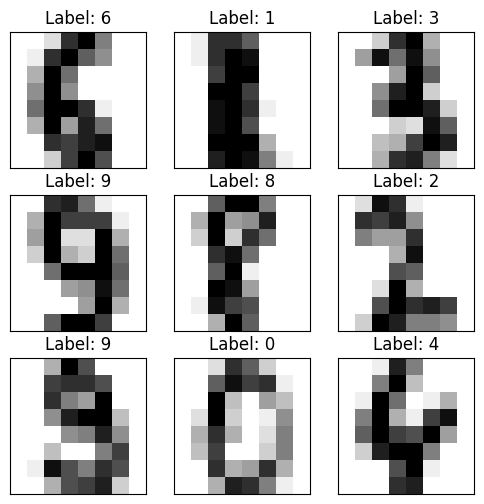

In [60]:
# Selecting 9 random indices
random_indices = np.random.choice(len(digits.images), 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

# gray_r plots in reversed grayscale
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest') 
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

As you can see, these images are very low resolution. This is because they were originally scanned from paper forms, and then scaled down to 8x8 pixels. This is a common problem in machine learning - the quality of the data is often a limiting factor in the performance of the model. In this case, the low resolution of the images makes it difficult to distinguish between some digits, even for humans. For example, the following images are all labelled as 9, but they look very different:

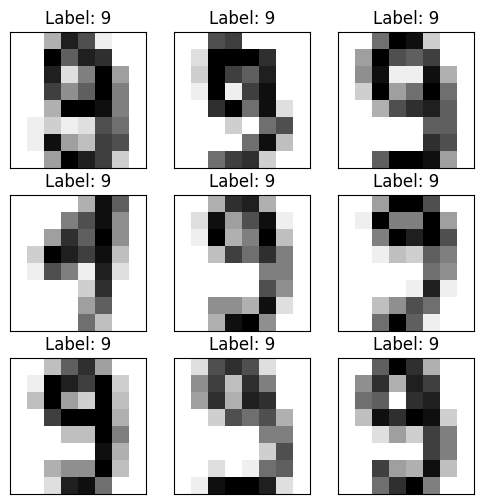

In [61]:
# Selecting 9 random indices of images labelled as 9
random_indices = np.random.choice(np.where(digits.target == 9)[0], 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

While we are plotting the samples as images, remember that our model is only going to see a 1D array of numbers. 

## Train / Test Split

In order to understand how well our model performs on _new_ data, we need to split our dataset into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the performance of the model.

Let's keep some held-out data to be able to measure the generalization performance of our model. 

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target,
    test_size=0.2, # 20% of the data is used for testing
    random_state=42 # Providing a value here means getting the same "random" split every time
)

Let's confirm that the data has been split correctly:

In [63]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1437, 64)
y_train shape: (1437,)
X_test shape: (360, 64)
y_test shape: (360,)


This is what we expected to see. It's always good to check as you go, to make sure that you haven't made a mistake somewhere - this is something that working in a notebook like this makes it easy to do.

## Preprocessing of the Target Data

The labels that we have are integers between 0 and 9. However, we want to train a neural network to classify the images into one of 10 classes. It can be a little counter-intuitive because we are dealing with numbers, but our classes are not ordinal.

**This means that although the labels are numbers (0 to 9), they do not have a natural order or ranking for the purpose of classification. In other words:

The classes (digits 0–9) are just categories.
The fact that "9" is greater than "1" is not meaningful for the model.
The model should treat each digit as a separate, unrelated class, not as points on a number line.
This is why we use one-hot encoding for the labels, so the neural network learns to classify each digit as a distinct class, not as an ordered value.

What do we mean by that? Let's imagine we were trying to predict the height of a building (separated into classes) from images. If a given building was actually 10m tall, and our model predicted 9m, we would consider that to be a better prediction than if it predicted 1m. This is because the classes are ordinal - there is meaning in the difference between the classes.

In our case, even though we are dealing with numbers, the classes are not ordinal. If a given image is actually a 9, and our model predicts 8, we would consider that to be just as bad as if it predicted 1. This is because the classes are not ordered, and the difference between the classes is not meaningful.

Because of this, we need to convert our labels from an integer value into a one-hot encoded vector. This means that each label will be represented as a vector of length 10, with a 1 in the position corresponding to the class, and 0s everywhere else. For example, the label 9 would be represented as `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`. This is a common way of representing categorical data in machine learning. By doing this, we ensure that our model is taught the correct relationship between the classes.

In [64]:
from tensorflow.keras.utils import to_categorical

print(f'Before one-hot encoding: {y_train[0]}')
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(f'After one-hot encoding: {y_train[0]}')

# Sample output:
# Before one-hot encoding: 6
# After one-hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

Before one-hot encoding: 6
After one-hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Feed Forward Neural Networks with Keras

Now that we have prepared our data, it's time to build a simple neural network! In this section, we will use the Keras API to build a simple feed forward neural network. We will then train the model on the MNIST dataset, and evaluate its performance on the test set.

In most modern deep learning frameworks, the process of building a model can be broken down into a few steps:

- Define the model architecture: this is where we define the layers of the model, and how they are connected to each other.
- Compile the model: this is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model.
- Train the model: this is where we train the model on the training data.

Let's start with defining the model architecture. There are two ways to do this in Keras - the Sequential API and the Functional API. The Sequential API is the simplest way to build a model, and is suitable for most use cases. The Functional API is more flexible, and allows you to build more complex models. We will start with the Sequential API, and then we will look at the Functional API later in the course.

Our simple neural network will be "fully-connected". This means that each neuron in a given layer is connected to every neuron in the next layer. This is also known as a "dense" layer. We will use the `Dense` class from Keras to define our layers.

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd

# Hidden layer
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.summary()

/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,970 (35.04 KB)

 Trainable params: 8,970 (35.04 KB)

 Non-trainable params: 0 (0.00 B)

Congratulations! You have just built your first neural network with Keras. As we can confirm from the `model.summary()` output, our model has 3 layers. The first layer has 64 neurons, the second layer has 64 neurons, and the output layer has 10 neurons. The output layer uses the softmax activation function, which is commonly used for multi-class classification problems. The other layers use the ReLU activation function, which is commonly used for hidden layers in neural networks.

*In the Output Shape, None is a placeholder for the batch size. It means the model can accept any number of samples in a batch (e.g., 32, 64, etc.).
64 is the number of neurons/units in that layer.
So, (None, 64) means: for each batch of inputs, the layer outputs an array with shape (batch_size, 64). The batch size is determined at runtime.

the "Param #" column shows the number of trainable parameters (weights and biases) in each layer of your neural network.

For a Dense (fully connected) layer, the number of parameters is calculated as: 
(number of input units × number of output units) + number of output units

The first part is for the weights. (The part (number of input units × number of output units) is the number of weights in a Dense layer.Each input is connected to each output neuron, so you need one weight for every connection.)
The second part is for the biases (one per output unit).
These parameters are what the model learns during training.

Weights: Each connection between neurons in one layer and the next has a weight. For a dense layer, every input is connected to every output neuron, so there are many weights.
Biases: Each output neuron also has a bias term, which is a single number added to the weighted sum for that neuron. There is one bias per output neuron.
During training, the model adjusts (learns) both the weights and the biases to minimize the loss and improve its predictions. These are the parameters that are updated by the optimizer.

Example:
If a layer has 64 inputs and 64 outputs:

First part (weights): 64 × 64 = 4096
Second part (biases): 64
Total parameters: 4096 + 64 = 4160
So, the formula counts both the weights and the biases that the model will learn during training.

The "Param #" values for each layer are:

First Dense layer (input: 64, output: 64):
Parameters = (64 inputs × 64 neurons) + 64 biases = 4160

Second Dense layer (input: 64, output: 64):
Parameters = (64 × 64) + 64 = 4160

Output Dense layer (input: 64, output: 10):
Parameters = (64 × 10) + 10 = 650

Total params: 4160 + 4160 + 650 = 8970

Next, we need to compile the model. This is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model. We will use the `compile` method of the model to do this.

In [66]:
model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer='sgd', # Optimizer = Stochastic Gradient Descent
    metrics=['accuracy'] # Metrics to evaluate the model
)

Because we are predicting which class a sample belongs to, we will use the `categorical_crossentropy` function. This loss function is commonly used for multi-class classification problems. 

For our optimizer, we are using the standard stochastic gradient descent (SGD) algorithm. This is a simple optimizer that works well for many problems. We will look at more advanced optimizers later in the course.

Finally, we are using the `accuracy` metric to evaluate the model. This is a common metric for classification problems, and it is simply the fraction of samples that are correctly classified. This is an easier metric for us to understand, but it's not quite as useful for actually training the model (for example, it doesn't tell us how "confident" the model is in its predictions).

Now that we have (a) defined the model architecture and (b) compiled the model, we are ready to train the model. We will use the `fit` method of the model to do this.

In [67]:
model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4004 - loss: 2.4598 - val_accuracy: 0.7812 - val_loss: 0.6453
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8320 - loss: 0.5455 - val_accuracy: 0.8681 - val_loss: 0.4406
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.3646 - val_accuracy: 0.8889 - val_loss: 0.3343
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.2480 - val_accuracy: 0.9062 - val_loss: 0.2964
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9427 - loss: 0.2177 - val_accuracy: 0.9167 - val_loss: 0.2457


We have now trained our model! We can see that the model has been trained for 5 epochs, and the loss and accuracy have been printed for each epoch. We can also see that the model has been evaluated on the validation data at the end of each epoch. This is useful for us to see how the model is performing on data that it hasn't seen during training.

*An epoch in model.fit is one complete pass through the entire training dataset.
During each epoch, the model sees every sample in the training data once, updates its weights, and then moves to the next epoch. Training for more epochs allows the model to learn better, up to a point.

Training set: 1797 × 0.8 = 1437.6 → 1437 samples (since train_test_split rounds down)
Test set: 1797 − 1437 = 360 samples

validation_split=0.2, so 20% of the training data is used for validation, and only 80% is used for actual training in each epoch:

Training samples per epoch: 1437 × 0.8 = 1149.6 → 1149 samples
Number of batches: 1149 / 32 ≈ 35.9 → 36 batches (rounded up)
So, 36 batches per epoch, each with up to 32 samples (the last batch may have fewer samples).

Once the model is trained, it's time to evaluate the model on the test set. We can use the `evaluate` method of the model to do this. If you were building a model for a real-world application, this is the very last thing you would do, and the result here would be the figure you'd report in your paper or presentation.

In [68]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9276 - loss: 0.2056  
Loss:     0.23
Accuracy: 91.39%


Hopefully you have achieved an accuracy of around 95%. This is pretty good, but we can do better! In the next section, we will look at how we can improve the performance of our model by using a more advanced optimizer. But before we get there, let's do one other thing - let's look at the predictions that our model is making on the test set. When you are building a model, it's often useful to have a look at some of the examples your model is getting wrong. Sometimes this can reveal problems with the data, or it can give you ideas for how to improve your model.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


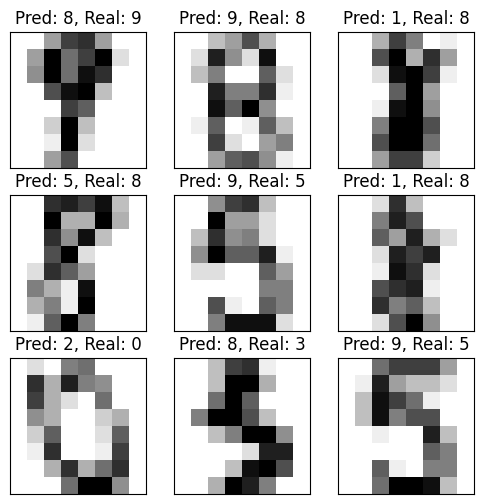

In [69]:
# Get the predictions for the test data
predictions = model.predict(X_test)

# Get the index of the largest probability (i.e. the predicted class)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Get the misclassified samples themselves
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = np.argmax(y_test[misclassified_indices], axis=1)

# Pick 9 random misclassified samples
random_indices = np.random.choice(len(misclassified_indices), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(misclassified_samples[random_indices[i]].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Pred: {predicted_classes[misclassified_indices[random_indices[i]]]}, Real: {misclassified_labels[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

What do you think? Would you have made the same mistakes as the model? Determining whether the mistakes are "understandable" is a rough way of seeing if you could improve the model further, or if this is the best you can do with the data you have.

### b) Exercises: Impact of the Optimizer

In this section, you will play around with the optimizer and see how it affects the performance of the model. We will start with the standard SGD optimizer, and then we will look at more advanced optimizers.

1. Try decreasing the learning rate of the SGD optimizer by a factor of 10, or 100. What do you observe?
2. Try increasing the learning rate of the SGD optimizer. What happens?
3. The SGD optimizer has a momentum parameter. In a nutshell, this parameter controls how much the gradient from the previous step affects the current step. Try enabling momentum in the SGD optimizer with a value of 0.9. What happens?
  
**Notes**: 

The keras API documentation is available at:

https://www.tensorflow.org/api_docs/python/tf/keras

It is also possible to learn more about the parameters of a class by using the question mark: type and evaluate:

```python
optimizers.SGD?
```

in a jupyter notebook cell.

It is also possible to type the beginning of a function call / constructor and type "shift-tab" after the opening paren:

```python
optimizers.SGD(<shift-tab>
```

In [70]:
# 1. Decreasing the learning rate

from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer= SGD(learning_rate = 0.0001), # Optimizer (default learning rate is 0.01)
    metrics=['accuracy'] # Metrics to evaluate the model
)

model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0830 - loss: 11.6719 - val_accuracy: 0.1319 - val_loss: 7.3145
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1186 - loss: 6.8207 - val_accuracy: 0.1701 - val_loss: 5.6266
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1572 - loss: 5.4063 - val_accuracy: 0.1771 - val_loss: 4.6605
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1778 - loss: 4.4769 - val_accuracy: 0.2014 - val_loss: 3.9517
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2016 - loss: 3.6997 - val_accuracy: 0.2292 - val_loss: 3.4546
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2344 - loss: 3.2656  
Loss:     3.29
Accuracy: 21.39%


In [71]:
# 2. Increasing the learning rate

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer= SGD(learning_rate = 0.2), # Optimizer #default learning rate is 0.01
    metrics=['accuracy'] # Metrics to evaluate the model
)

model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1106 - loss: 83.7531 - val_accuracy: 0.1076 - val_loss: 2.3066
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1212 - loss: 2.3052 - val_accuracy: 0.1076 - val_loss: 2.3094
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1100 - loss: 2.3011 - val_accuracy: 0.1076 - val_loss: 2.3111
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1197 - loss: 2.2991 - val_accuracy: 0.0833 - val_loss: 2.3112
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0997 - loss: 2.3042 - val_accuracy: 0.0833 - val_loss: 2.3118
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0909 - loss: 2.3121  
Loss:     2.31
Accuracy: 9.44%


In [72]:
# 3. SGD with momentum = 0.9

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer= SGD(learning_rate = 0.01, momentum = 0.9), # Optimizer #default learning rate is 0.01
    metrics=['accuracy'] # Metrics to evaluate the model
)

model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3740 - loss: 3.5134 - val_accuracy: 0.8299 - val_loss: 0.5822
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8937 - loss: 0.2793 - val_accuracy: 0.9062 - val_loss: 0.3381
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9530 - loss: 0.1536 - val_accuracy: 0.9062 - val_loss: 0.2608
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9617 - loss: 0.1078 - val_accuracy: 0.9340 - val_loss: 0.2039
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9755 - loss: 0.0699 - val_accuracy: 0.9479 - val_loss: 0.1943
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9759 - loss: 0.0941  
Loss:     0.15
Accuracy: 95.56%


Next, let's try a more advanced optimizer. Adam is likely the most popular optimizer for deep learning. It is an adaptive learning rate optimizer, which means that it automatically adjusts the learning rate based on how the training is going. This can be very useful, as it means that we don't need to manually tune the learning rate. Let's see how it performs on our model.

*The Adam optimizer is an advanced optimization algorithm used to train neural networks.
Adam stands for Adaptive Moment Estimation. It combines the benefits of two other extensions of stochastic gradient descent: AdaGrad (which works well with sparse gradients) and RMSProp (which works well in online and non-stationary settings).

Adam automatically adjusts the learning rate for each parameter, using estimates of the first (mean) and second (uncentered variance) moments of the gradients. This usually leads to faster and more stable convergence compared to standard SGD.

1. Replace the SGD optimizer by the Adam optimizer from keras and run it
  with the default parameters.

2. Add another hidden layer with ReLU activation and 64 neurons. Does it improve the model performance?


In [73]:
# Adam optimizer

from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer = Adam(),
    metrics=['accuracy'] # Metrics to evaluate the model
)

model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1553 - loss: 4.7871 - val_accuracy: 0.6667 - val_loss: 1.0649
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7515 - loss: 0.8224 - val_accuracy: 0.8542 - val_loss: 0.4639
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9061 - loss: 0.3550 - val_accuracy: 0.9132 - val_loss: 0.2950
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9422 - loss: 0.2219 - val_accuracy: 0.9167 - val_loss: 0.2400
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9681 - loss: 0.1397 - val_accuracy: 0.9201 - val_loss: 0.2200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9491 - loss: 0.1821  
Loss:     0.22
Accuracy: 93.33%


In [74]:
# Extra hidden layer

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64, input_shape no longer req'd
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation
model.add(Dense(64, activation='relu')) # extra hidden layer with 64 neurons, ReLU activation
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer= SGD(learning_rate = 0.01), # Optimizer #default learning rate is 0.01
    metrics=['accuracy'] # Metrics to evaluate the model
)

model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=5, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3751 - loss: 2.3141 - val_accuracy: 0.7569 - val_loss: 0.7655
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8338 - loss: 0.5600 - val_accuracy: 0.7604 - val_loss: 0.7023
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8983 - loss: 0.3593 - val_accuracy: 0.8750 - val_loss: 0.3782
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9314 - loss: 0.2406 - val_accuracy: 0.8889 - val_loss: 0.3939
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9477 - loss: 0.1752 - val_accuracy: 0.8958 - val_loss: 0.3380
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9402 - loss: 0.2462  
Loss:     0.28
Accuracy: 93.06%


### Exercises: Forward Pass and Generalization

Let's look in more detail at how the model makes predictions on the test set. We will walk through each step of making predictions, examining exactly what's going on.

To start, we will apply our model to the test set, and look at what we get as output:

In [75]:
predictions_tf = model(X_test)
predictions_tf[:5]

# model(X_test) computes the output of the model for all test samples.
# Each row in predictions_tf is a vector of 10 numbers (for 10 classes), representing the predicted probabilities for each digit (0–9) for one sample.
# predictions_tf[:5] displays the predicted probability distributions for the first 5 test samples.
# Each row sums to (about) 1, and the highest value in each row is the model's predicted class for that sample.

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.55496125e-04, 1.14509999e-03, 1.30266941e-03, 7.62929812e-06,
        1.01591377e-02, 1.15234077e-04, 9.82831597e-01, 2.23054267e-05,
        3.54328379e-03, 6.17595622e-04],
       [1.03055257e-02, 8.29286000e-05, 3.86409811e-04, 8.00274219e-03,
        7.57319940e-05, 1.54704018e-03, 2.16903190e-05, 1.15799194e-04,
        3.18484847e-03, 9.76277173e-01],
       [3.27673988e-05, 1.74392517e-05, 1.75221241e-03, 9.96951103e-01,
        1.15728835e-05, 3.28200658e-05, 8.08855257e-05, 1.57683698e-05,
        7.84898526e-04, 3.20449239e-04],
       [2.06751851e-04, 8.01082421e-03, 2.03142510e-04, 1.05247693e-03,
        1.10598076e-02, 6.86440021e-02, 4.24696977e-04, 7.86248803e-01,
        1.28529007e-02, 1.11296564e-01],
       [7.37009163e-04, 2.63655395e-03, 8.19680512e-01, 1.69835016e-01,
        1.32281630e-05, 2.03991385e-05, 4.51298291e-03, 1.61863391e-05,
        2.47219624e-03, 7.59623435e-05]], dtype=float32)>

In [76]:
type(predictions_tf), predictions_tf.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([360, 10]))

The raw output of the model is a tensor of shape `(360, 10)`. This means that we have 360 samples, and for each sample we have 10 values. Each of these values represents the probability that the sample belongs to a given class. This means that we have 10 probabilities for each sample, and the sum of these probabilities is 1. We can confirm this by summing the probabilities for each sample:

In [77]:
import tensorflow as tf

tf.reduce_sum(predictions_tf, axis=1)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.        , 0.9999999 , 0.99999994, 1.        , 1.0000001 ],
      dtype=float32)>

...okay, there might be a small rounding error here and there. This is to do with how floating point numbers are represented in computers, and it's not something we need to worry about for now.

We can also extract the label with the highest probability using the tensorflow API:

In [78]:
predicted_labels_tf = tf.argmax(predictions_tf, axis=1)
predicted_labels_tf[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 9, 3, 7, 2])>

One helpful aspect of this approach is that we don't just get the prediction, but also a sense of how confident the model is in its prediction. To see this in practice, let's take a look at some of the predictions the model is highly confident about (i.e. a lot of the probability mass is on one class):

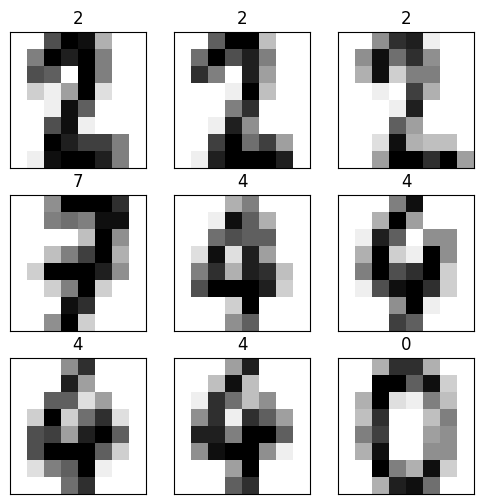

In [79]:
# Get the values corresponding to the predicted labels for each sample
predicted_values_tf = tf.reduce_max(predictions_tf, axis=1)

# Get the indices of the samples with the highest predicted values
most_confident_indices_tf = tf.argsort(predicted_values_tf, direction='DESCENDING').numpy()[:9]

# Get the 9 most confident samples
most_confident_samples_tf = X_test[most_confident_indices_tf]

# Get the true labels for the 9 most confident samples
most_confident_labels_tf = np.argmax(y_test[most_confident_indices_tf], axis=1)

# Plot the 9 most confident samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(most_confident_samples_tf[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"{most_confident_labels_tf[i]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

## Impact of Initialization

Let's study the impact of a bad initialization when training
a deep feed forward network.

By default, Keras dense layers use the "Glorot Uniform" initialization
strategy to initialize the weight matrices:

- each weight coefficient is randomly sampled from [-scale, scale]
- scale is proportional to $\frac{1}{\sqrt{n_{in} + n_{out}}}$

This strategy is known to work well to initialize deep neural networks
with "tanh" or "relu" activation functions and then trained with
standard SGD.

To assess the impact of initialization let us plug an alternative init
scheme into a 2 hidden layers networks with "tanh" activations.
For the sake of the example let's use normal distributed weights
with a manually adjustable scale (standard deviation) and see the
impact the scale value:

Using TruncatedNormal instead of a full normal distribution when initializing neural network weights is a deliberate choice to improve training stability. 

A full normal distribution (i.e., RandomNormal) can produce values far from the mean — extreme values (outliers) in the tails of the distribution.

These large values can:

Lead to exploding activations or gradients, especially in deep networks.

Cause slower convergence or make training unstable.

It generates values from a normal distribution but truncates (cuts off) the values that fall more than 2 standard deviations from the mean.

initializers.TruncatedNormal(stddev=0.01, seed=42)
You are drawing from:

A normal distribution with mean 0, stddev 0.01

But only values in the range [-0.02, 0.02] (approximately 95% of values)

Outliers are rejected and redrawn until they fall within this range.

In [89]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

# weights set randomly using truncated normal distribution, width determines
# spread of possible values (wider=more possible values)
# dictates variability in the random weights
normal_init = initializers.TruncatedNormal(stddev=0.01, seed=42)

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.layers

[<Dense name=dense_45, built=True>,
 <Dense name=dense_46, built=True>,
 <Dense name=dense_47, built=True>]

Let's have a look at the parameters of the first layer after initialization but before any training has happened:
(bias terms are all zero)

In [82]:
model.layers[0].weights

[<Variable path=sequential_14/dense_45/kernel, shape=(64, 64), dtype=float32, value=[[ 0.00015817 -0.01590087  0.00103594 ...  0.00962818  0.00624957
    0.00994726]
  [ 0.0081879   0.00756818 -0.00668142 ...  0.01084459 -0.00317478
   -0.00549116]
  [-0.00086618 -0.00287623  0.00391693 ...  0.00064558 -0.00420471
    0.00174566]
  ...
  [-0.0029006  -0.0091218   0.00804327 ... -0.01407086  0.00952832
   -0.01348555]
  [ 0.00375078  0.00967842  0.00098119 ... -0.00413454  0.01695471
    0.00025196]
  [ 0.00459809  0.01223094 -0.00213172 ...  0.01246831 -0.00714749
   -0.00868595]]>,
 <Variable path=sequential_14/dense_45/bias, shape=(64,), dtype=float32, value=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]>]

In [83]:
w = model.layers[0].weights[0].numpy()
w

array([[ 0.00015817, -0.01590087,  0.00103594, ...,  0.00962818,
         0.00624957,  0.00994726],
       [ 0.0081879 ,  0.00756818, -0.00668142, ...,  0.01084459,
        -0.00317478, -0.00549116],
       [-0.00086618, -0.00287623,  0.00391693, ...,  0.00064558,
        -0.00420471,  0.00174566],
       ...,
       [-0.0029006 , -0.0091218 ,  0.00804327, ..., -0.01407086,
         0.00952832, -0.01348555],
       [ 0.00375078,  0.00967842,  0.00098119, ..., -0.00413454,
         0.01695471,  0.00025196],
       [ 0.00459809,  0.01223094, -0.00213172, ...,  0.01246831,
        -0.00714749, -0.00868595]], dtype=float32)

In [84]:
w.std() # almost 0.01

0.008835949

In [ ]:
b = model.layers[0].weights[1].numpy()
b # bias terms should all be zero

array([-6.5031566e-04, -2.3810617e-03,  2.0126246e-03,  3.1350658e-03,
       -4.7824858e-03, -1.5611367e-03, -1.6464709e-03, -4.4282389e-04,
        6.1545608e-04, -1.5527215e-03,  1.1428574e-03,  4.7056931e-03,
        2.4700260e-03,  1.9528392e-03,  3.2314043e-03, -1.6254173e-03,
        2.1398757e-03,  9.5339346e-04, -2.6786963e-03, -7.6903868e-04,
        5.6050898e-04,  1.5342731e-03,  2.7517856e-03,  1.5462973e-03,
        9.2599244e-04, -6.5018208e-04,  2.8589207e-03,  1.1376509e-03,
       -1.8046871e-04, -8.0275477e-04,  4.1328082e-03,  1.5821721e-04,
        1.0026674e-03,  5.4590823e-04, -1.4679699e-04, -1.2542108e-03,
       -9.7592222e-04, -9.0944243e-04, -2.5103791e-03,  5.3326925e-03,
        1.6930390e-03, -5.7878188e-04,  3.4829662e-03,  7.4677507e-04,
        1.7998375e-03, -1.2286941e-03,  4.8131505e-03, -1.5808081e-03,
        1.1871908e-03,  2.2531233e-03, -3.5986977e-03, -4.8321579e-03,
       -6.3807620e-03, -3.3209745e-03, -7.2699017e-04, -4.1067661e-03,
      

There are 45 batches because we set batch_size=32 and our training set has 1,437 samples (after the 80/20 train/test split).

Number of batches per epoch is calculated as:

number_of_batches = ceil(number_of_samples / batch_size)
                  = ceil(1437 / 32)
                  = ceil(44.90625)
                  = 45

So, each epoch processes 45 batches to cover all 1,437 training samples. The last batch will have fewer than 32 samples.

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1694 - loss: 2.2979
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4033 - loss: 1.9497
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6660 - loss: 1.1734
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8603 - loss: 0.5822
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9269 - loss: 0.2986
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9524 - loss: 0.1967
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9381 - loss: 0.1995
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.1274
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.0960
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9774 - loss: 0.1011
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0561
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - lo

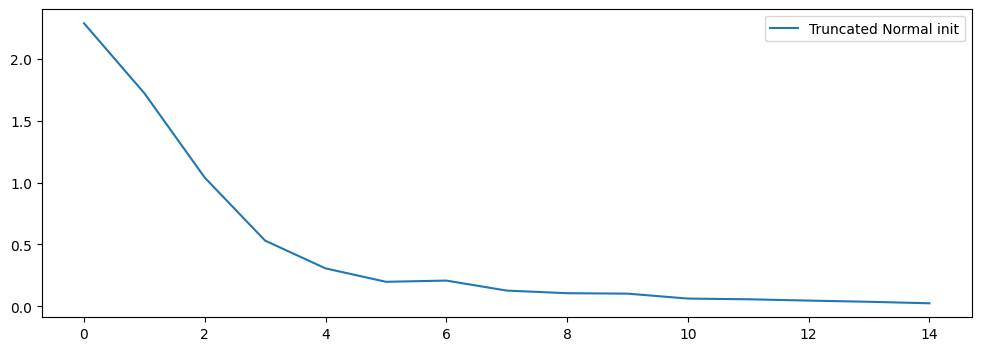

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

# We call it history because the object returned by model.fit() 
# contains the training history—that is, it records how the loss 
# and metrics (like accuracy) changed over each epoch during training.

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init")
plt.legend();

Model performance improves as epochs increase (loss decreases).

Once the model has been fit, the weights have been updated and notably the biases are no longer 0:

In [46]:
model.layers[0].weights

[<Variable path=sequential_7/dense_23/kernel, shape=(64, 64), dtype=float32, value=[[ 1.58170762e-04 -1.59008689e-02  1.03594456e-03 ...  9.62818228e-03
    6.24957308e-03  9.94726177e-03]
  [ 1.39925256e-02 -1.45683084e-02 -8.54570977e-03 ... -2.15892326e-02
   -2.14302652e-02 -3.10514923e-02]
  [ 4.68970053e-02 -5.76289222e-02 -8.96411091e-02 ... -4.01431099e-02
   -9.74485278e-02  7.31572062e-02]
  ...
  [ 5.75846666e-03 -2.95721218e-02  1.56831935e-01 ... -9.43908617e-02
    5.53193875e-02 -2.16679290e-01]
  [ 1.41990650e-02 -4.04022858e-02  1.15425445e-01 ... -1.05854943e-01
   -1.78529005e-02 -1.24890886e-01]
  [ 3.64422873e-02  1.03733921e-02  5.30855358e-02 ...  6.24848790e-02
    2.02606451e-02 -5.40204421e-02]]>,
 <Variable path=sequential_7/dense_23/bias, shape=(64,), dtype=float32, value=[-6.5031566e-04 -2.3810617e-03  2.0126246e-03  3.1350658e-03
  -4.7824858e-03 -1.5611367e-03 -1.6464709e-03 -4.4282389e-04
   6.1545608e-04 -1.5527215e-03  1.1428574e-03  4.7056931e-03
   2

#### Questions:

- Try the following initialization schemes and see whether
  the SGD algorithm can successfully train the network or
  not:
  
  - a very small e.g. `stddev=1e-3`
  - a larger scale e.g. `stddev=1` or `10`
  - initialize all weights to 0 (constant initialization)
  
- What do you observe? Can you find an explanation for those
  outcomes?

- Are more advanced solvers such as SGD with momentum or Adam able
  to deal better with such bad initializations?

Epoch 1/15


/home/labber/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0970 - loss: 2.3029
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0751 - loss: 2.3030
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1155 - loss: 2.3028
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1153 - loss: 2.3022
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1087 - loss: 2.3030
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1211 - loss: 2.3022
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1078 - loss: 2.3029
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1003 - loss: 2.3028
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1085 - loss: 2.3029
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1524 - loss: 2.2379
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1945 - loss: 1.8274
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2549 - loss: 1.6873


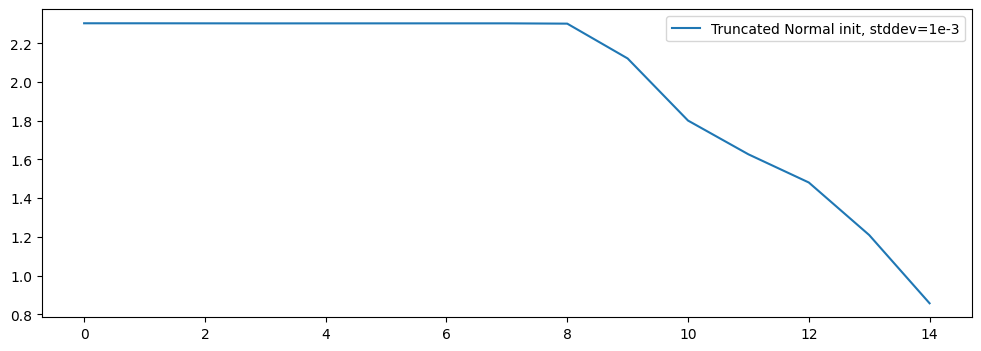

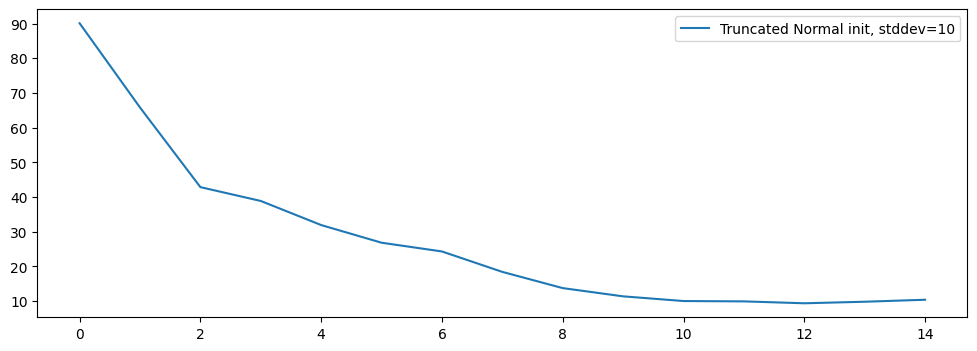

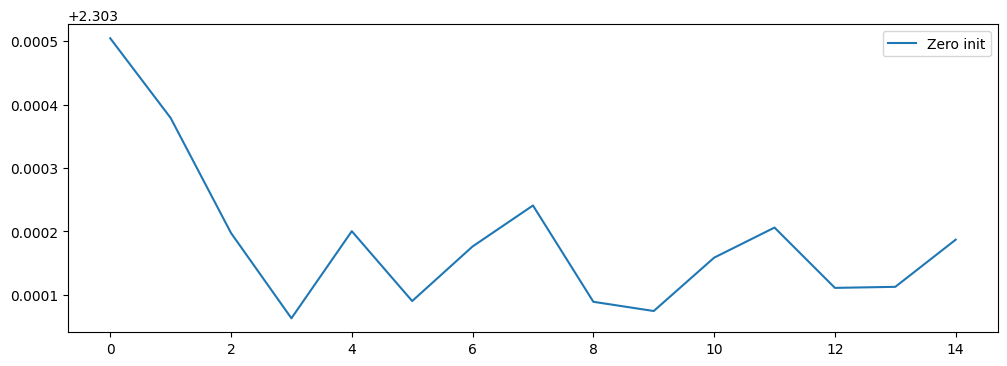

In [88]:
# stdev=1e-3
normal_init = initializers.TruncatedNormal(stddev=1e-3, seed=42)
model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))
model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32)
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init, stddev=1e-3")
plt.legend();

# stdev=10
normal_init = initializers.TruncatedNormal(stddev=10, seed=42)
model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))
model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32)
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init, stddev=10")
plt.legend();

# weights all set to zero

zero_init = initializers.Zeros()
model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=zero_init))
model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=zero_init))
model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=zero_init))
model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32)
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Zero init")
plt.legend();

Small stddev: not much difference between neurons, takes a long time before model starts training

Large stddev: distribution of initial weights high, improvement as epochs increase, but start with much higher eror

Zero init weights: no learning happening, range of change in weights (y-axis) almost zero

If all weights are set to zero, then the only thing impacting the output of the neuron is the bias term, since all inputs are mulitplied by zero.  In practice we would never do this as this breaks learning and defeats the purpose of having a neural network.